In [1]:
import pandas as pd
import numpy as np
import json
import csv
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
warnings.filterwarnings('ignore')

In [2]:
def load_df(file_path,var): #we will set dateTime as unique id to merge datasets
    with open(file_path, 'r') as json_file:
        js = json.load(json_file)
    df = pd.DataFrame(js)
    df.drop_duplicates(subset=['dateTime'],inplace=True)
    df = df.dropna(subset=['dateTime'])

    df.columns = ['dateTime', var+'_value']
    df['dateTime'] = pd.to_datetime(df['dateTime'], errors='coerce')
    df = df.astype({var+'_value': float})
    
    return df

In [3]:
def get_data(path,id):
    paths = [path + '\\calories.json',path + '\\steps.json', path + '\\distance.json']
    vars = ['calories', 'steps', 'distance']
    df = pd.DataFrame(columns =['dateTime'] )
    for p,v in zip(paths,vars):
        df = pd.merge(df, load_df(p,v), on='dateTime', how='outer')
    #first three metrics are ready, now preparing heart rate
    
    heart_rate_path = path + '\\heart_rate.json'
    with open(heart_rate_path, 'r') as json_file:
        js = json.load(json_file)
    
    hr = json_normalize(js)
    hr.columns = ['dateTime','value_bpm','value_confidence']
    hr['dateTime'] = pd.to_datetime(df['dateTime'], errors='coerce')
    hr = hr.dropna(subset=['dateTime'])
    hr = hr.astype({'value_bpm': float,'value_confidence': float})
    hr.drop_duplicates(subset=['dateTime'],inplace=True)
    
    #given heart rate is in for every 5 seconds
    #we will combine the data by minute and merge with our dataframe

    hr['minute'] = hr['dateTime'].dt.floor('min')
    hr['confidence_value'] = hr.groupby('minute')['value_confidence'].transform('mean')
    hr['bpm_value'] = hr.groupby('minute')['value_bpm'].transform('mean')

    hr.drop(columns=['value_confidence','value_bpm','dateTime'],inplace=True)
    hr = hr.rename(columns={'minute': 'dateTime'})
    hr.drop_duplicates(subset=['dateTime'],inplace=True)
    #print(hr.info,hr.head())

    df = pd.merge(df, hr, on='dateTime', how='outer')
    df['person_id'] = id

    print("data loaded for ",id)
    
    return df

In [4]:
people = ['p01','p02','p03','p04','p05','p06','p07','p08','p09','p10','p11','p12','p13','p14','p15','p16']
ids = list(range(1, 17))

print("Loading Data... .")
data = pd.DataFrame()
for p,i in zip(people,ids):
    path = p + "\\fitbit\\"
    data = pd.concat([data,get_data(path,i)])

data = data.dropna(subset=['dateTime'])
data.to_csv('fitbit.csv',index =False)
print(data.info())




Loading Data... .
data loaded for  1
data loaded for  2
data loaded for  3
data loaded for  4
data loaded for  5
data loaded for  6
data loaded for  7
data loaded for  8
data loaded for  9
data loaded for  10
data loaded for  11
data loaded for  12
data loaded for  13
data loaded for  14
data loaded for  15
data loaded for  16
<class 'pandas.core.frame.DataFrame'>
Index: 3397574 entries, 0 to 218879
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   dateTime          datetime64[ns]
 1   calories_value    float64       
 2   steps_value       float64       
 3   distance_value    float64       
 4   confidence_value  float64       
 5   bpm_value         float64       
 6   person_id         int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 207.4 MB
None


In [5]:
print(data.head())

             dateTime  calories_value  steps_value  distance_value  \
0 2019-11-01 00:00:00            1.39          0.0             0.0   
1 2019-11-01 00:01:00            1.39          0.0             0.0   
2 2019-11-01 00:02:00            1.39          0.0             0.0   
3 2019-11-01 00:03:00            1.39          0.0             0.0   
4 2019-11-01 00:04:00            1.39          0.0             0.0   

   confidence_value  bpm_value  person_id  
0               3.0       54.0          1  
1               3.0       52.0          1  
2               3.0       51.0          1  
3               3.0       52.0          1  
4               3.0       51.0          1  


1. Loading the dataset...
Initial shape of dataset: (3397574, 7)

2. Initial Data Exploration

First few rows:
              dateTime  calories_value  steps_value  distance_value  \
0  2019-11-01 00:00:00            1.39          0.0             0.0   
1  2019-11-01 00:01:00            1.39          0.0             0.0   
2  2019-11-01 00:02:00            1.39          0.0             0.0   
3  2019-11-01 00:03:00            1.39          0.0             0.0   
4  2019-11-01 00:04:00            1.39          0.0             0.0   

   confidence_value  bpm_value  person_id  
0               3.0       54.0          1  
1               3.0       52.0          1  
2               3.0       51.0          1  
3               3.0       52.0          1  
4               3.0       51.0          1  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3397574 entries, 0 to 3397573
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date

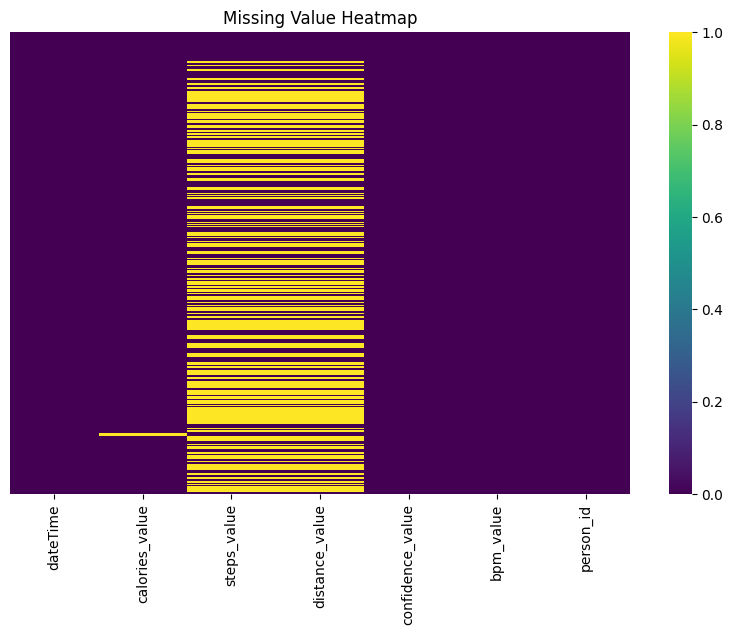


4. Data Cleaning

Removed 0 duplicate rows

Complete case analysis shape: (1514034, 7)

5. Outlier Detection and Treatment

6. Data Validation

Validation Results:
steps_value: {'invalid_count': 0, 'min_value': np.float64(0.0), 'max_value': np.float64(0.0)}
calories_value: {'invalid_count': 0, 'min_value': np.float64(0.5299999999999997), 'max_value': np.float64(2.2100000000000004)}
distance_value: {'invalid_count': 0, 'min_value': np.float64(0.0), 'max_value': np.float64(0.0)}
confidence_value: {'invalid_count': 0, 'min_value': np.float64(0.5), 'max_value': np.float64(3.0)}
person_id: {'invalid_count': 0, 'min_value': np.int64(1), 'max_value': np.int64(16)}
bpm_value: {'invalid_count': 2073, 'min_value': np.float64(36.0), 'max_value': np.float64(114.0)}

7. Feature Engineering

8. Generate Summary Statistics

Numerical Features Summary:
                       mean  median        std      skew
calories_value     1.439347    1.32   0.405175  0.923328
steps_value        0.000000    0.00 

In [6]:
def eda_analysis(name):
    path = name+'.csv'
    # 1. Data Loading
    print("1. Loading the dataset...")
    df = pd.read_csv(path)#'fitbit.csv'
    print(f"Initial shape of dataset: {df.shape}")
    
    # 2. Initial Data Exploration
    print("\n2. Initial Data Exploration")
    print("\nFirst few rows:")
    print(df.head())
    
    print("\nDataset Info:")
    print(df.info())
    
    print("\nBasic statistics:")
    print(df.describe())
    
    print("\n3. Missing Value Analysis")
    missing_stats = {
        col: {
            'missing_count': df[col].isnull().sum(),
            'missing_percentage': (df[col].isnull().sum() / len(df) * 100),
            'data_type': str(df[col].dtype)
        }
        for col in df.columns
    }
    
    missing_df = pd.DataFrame.from_dict(missing_stats, orient='index')
    print("\nMissing value analysis:")
    print(missing_df[missing_df['missing_count'] > 0])
    
    # Visualize missing values
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
    plt.title('Missing Value Heatmap')
    plt.show()
    
    
    
    # 4. Data Cleaning
    print("\n4. Data Cleaning")
    
    # 4.1 Remove duplicates
    initial_rows = len(df)
    df = df.drop_duplicates()
    print(f"\nRemoved {initial_rows - len(df)} duplicate rows")
    
    # 4.2 Create two copies for different cleaning approaches
    df_complete_case = df.copy()
    df_imputed = df.copy()
    
    # Complete Case Analysis
    df_complete_case = df_complete_case.dropna()
    print(f"\nComplete case analysis shape: {df_complete_case.shape}")
    
    # 4.3 Custom imputation using pandas and numpy
    # Separate numerical and categorical columns using list comprehension
    numerical_columns = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    
    # Function for rolling window imputation
    def rolling_window_impute(series, window=3):
        return series.fillna(series.rolling(window=window, min_periods=1, center=True).mean())
    
    # Impute numerical columns using rolling window and mean
    for col in numerical_columns:   
        # First try rolling window imputation
        #df_imputed[col] = rolling_window_impute(df_imputed[col])
        # Fill any remaining NaN with column mean
        df_imputed[col].fillna(0, inplace=True)#df_imputed[col].mean()
    
    # Impute categorical columns with mode
    for col in categorical_columns:
        df_imputed[col].fillna(df_imputed[col].mode()[0], inplace=True)
    
    # 5. Outlier Detection and Treatment using numpy
    print("\n5. Outlier Detection and Treatment")
    
    # Dictionary comprehension for column statistics
    column_stats = {
        col: {
            'q1': df_imputed[col].quantile(0.25),
            'q3': df_imputed[col].quantile(0.75),
            'iqr': df_imputed[col].quantile(0.75) - df_imputed[col].quantile(0.25)
        }
        for col in numerical_columns
    }
    
    # Treat outliers using IQR method
    for col in numerical_columns:
        stats = column_stats[col]
        lower_bound = stats['q1'] - 1.5 * stats['iqr']
        upper_bound = stats['q3'] + 1.5 * stats['iqr']
        df_imputed[col] = df_imputed[col].clip(lower_bound, upper_bound)
    
    
    # 6. Data Validation using dictionary comprehension
    print("\n6. Data Validation")
    
    validation_rules = {
        'steps_value': (0, 50000),
        'calories_value': (0, 10000),
        'distance_value': (0, 100),
        'confidence_value': (0, 6),
        'person_id': (0, 17),
        'bpm_value': (40, 200)
    }
    
    # Dictionary comprehension for validation results
    validation_results = {
        col: {
            'invalid_count': len(df_imputed[(df_imputed[col] < limits[0]) | (df_imputed[col] > limits[1])]),
            'min_value': df_imputed[col].min(),
            'max_value': df_imputed[col].max()
        }
        for col, limits in validation_rules.items()
    }
    
    print("\nValidation Results:")
    for col, results in validation_results.items():
        print(f"{col}: {results}")
        if results['invalid_count'] > 0:
            df_imputed[col] = df_imputed[col].clip(validation_rules[col][0], validation_rules[col][1])
    
    
    # 7. Feature Engineering
    # Add day of week
    print("\n7. Feature Engineering")
    df_imputed['day_of_week'] = pd.to_datetime(df_imputed['dateTime']).dt.day_name()
    
    
    # 8. Create summary statistics using dictionary comprehension
    print("\n8. Generate Summary Statistics")
    
    summary_stats = {
        col: {
            'mean': df_imputed[col].mean(),
            'median': df_imputed[col].median(),
            'std': df_imputed[col].std(),
            'skew': df_imputed[col].skew()
        }
        for col in numerical_columns
    }
    
    print("\nNumerical Features Summary:")
    print(pd.DataFrame.from_dict(summary_stats, orient='index'))
    
    
    # Save cleaned datasets
    df_complete_case.to_csv(name+'_data_complete_case.csv', index=False)
    df_imputed.to_csv(name+'_data_imputed.csv', index=False)
    
    print("\nAnalysis completed! New features and improvements added:")
    print("1. Custom rolling window imputation using pandas")
    print("2. Dictionary comprehension for statistics and validation")
    print("3. List comprehension for feature engineering")




eda_analysis('fitbit')



In [7]:
def correlations(path_imputed):
    df = pd.read_csv(path_imputed)#'fitbit_data_imputed.csv'
    numerical_cols = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]
    # 1. Data Quality Visualization
    plt.figure(figsize=(15, 10))
    
    # Distribution plots for numerical features
    
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(4, 4, i)
        sns.histplot(data=df, x=col, kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()
    
    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[numerical_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')
    plt.show()
    
    # Box plots for outlier visualization
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(4, 4, i)
        sns.boxplot(data=df, y=col)
        plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()


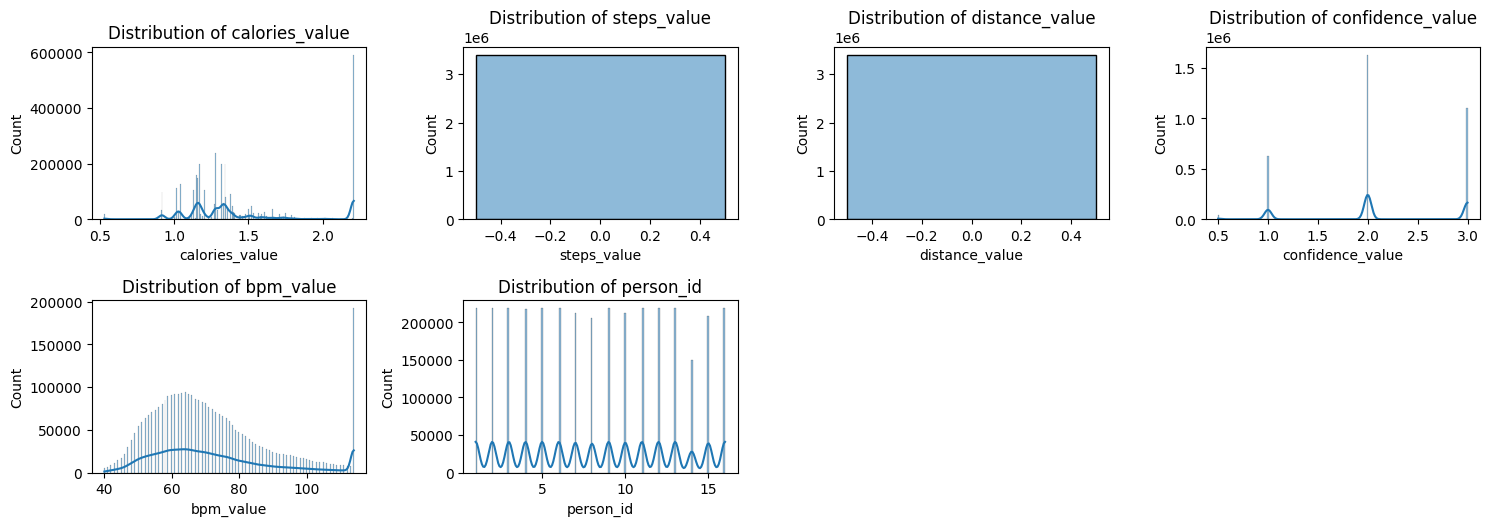

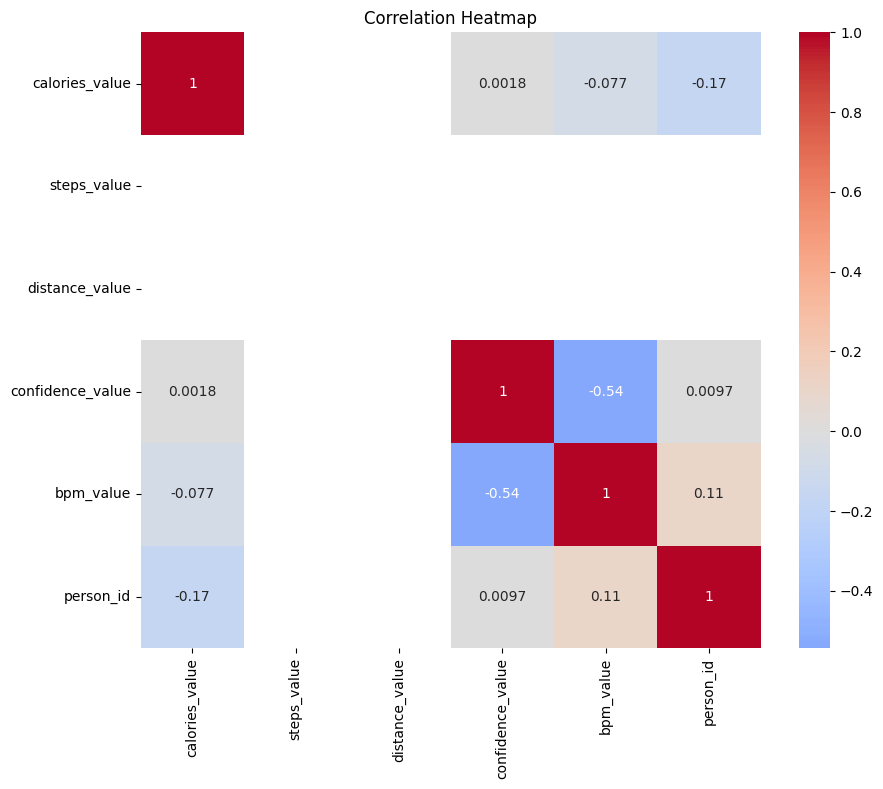

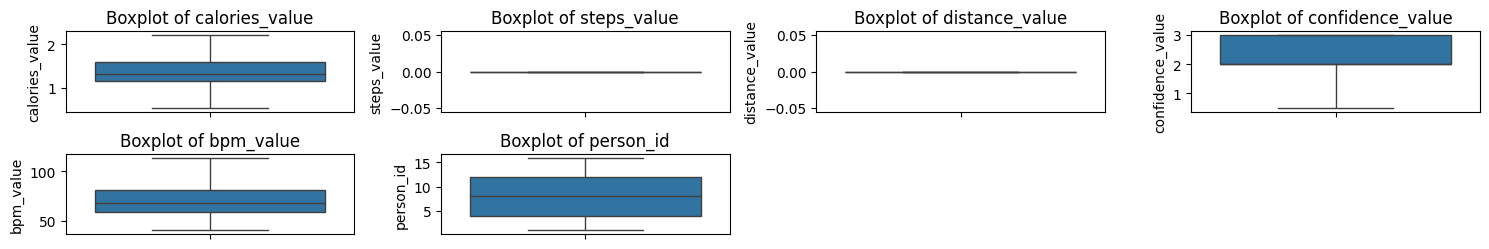

In [8]:
correlations('fitbit_data_imputed.csv')